In [2]:
import h5py
import numpy as np
import optuna
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from dataset import EnergyDataset
from model import LightningFullyConnected

DATA_DIR = "/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial"

In [3]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[-1]
        return pd.DataFrame(f[filename][:], dtype=np.float32)

train = load_data(f'{DATA_DIR}/train')
test  = load_data(f'{DATA_DIR}/test')

all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

electrons = train['Truth']

opt_features = ['p_deltaEta2', 'p_EptRatio', 'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_deltaPhi2', 'p_pt_track', 'p_qOverP', 'p_d0', 'p_eCluster', 'p_Rphi', 'p_sigmad0', 'p_d0Sig', 'p_nCells_Lr1_HiG', 'p_ptconecoreTrackPtrCorrection', 'p_deltaPhiFromLastMeasurement', 'p_nCells_Lr2_HiG', 'p_weta1', 'p_Reta', 'p_deltaPhi1', 'p_weta2']

X = train[opt_features][electrons == 1]
y = train["p_truth_E"][electrons == 1]

In [4]:
scaler_x = RobustScaler(quantile_range=[10, 90]).fit(X)
scaler_y = StandardScaler().fit(y.values.reshape(-1, 1))

y_transformed = scaler_y.transform(y.values.reshape(-1, 1))
X_transformed = scaler_x.transform(X)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

In [7]:
cat = CatBoostRegressor(verbose=False, task_type="GPU")
lgbm = LGBMRegressor()

cat.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

def rel_mae(y_true, y_pred, y_scaler=scaler_y):
    return np.mean(np.abs((y_scaler.inverse_transform(y_pred.reshape(-1, 1))
                          - (y_t := y_scaler.inverse_transform(y_true.reshape(-1, 1))))
                          / y_t))

print("cat", rel_mae(y_val, cat.predict(X_val)))
print("lgbm", rel_mae(y_val, lgbm.predict(X_val)))

/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cat 0.06670297040982612
lgbm 0.06797887014106505


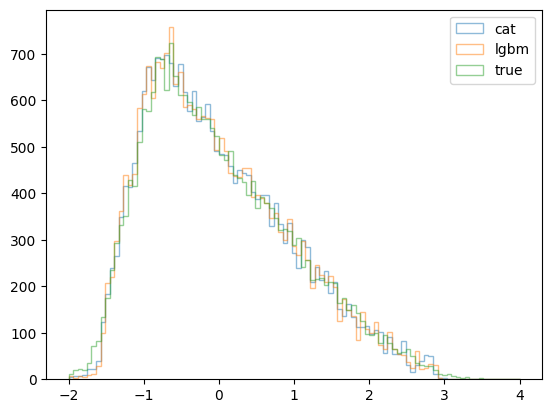

In [8]:
from matplotlib import pyplot as plt

bins = np.linspace(-2, 4, 100)
plt.hist(cat.predict(X_val), bins=bins, alpha=0.5, label="cat", histtype="step")
plt.hist(lgbm.predict(X_val), bins=bins, alpha=0.5, label="lgbm", histtype="step")
plt.hist(y_val, bins=bins, alpha=0.5, label="true", histtype="step")
plt.legend()

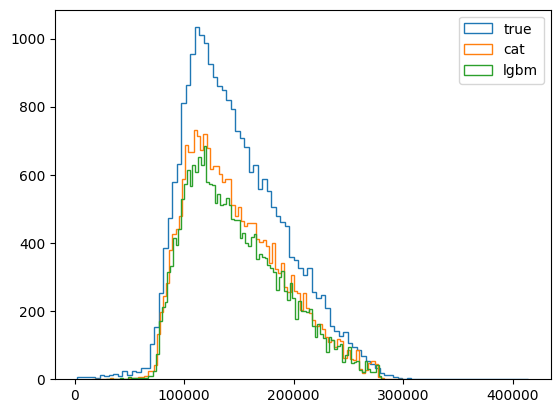

In [10]:
plt.hist(scaler_y.inverse_transform(y_val.reshape(-1, 1)), bins=100, histtype="step", label="true")
plt.hist(scaler_y.inverse_transform(cat.predict(X_val).reshape(-1, 1)), bins=100, histtype="step", label="cat")
plt.hist(scaler_y.inverse_transform(lgbm.predict(X_val).reshape(-1, 1)), bins=100, histtype="step", label="lgbm")
plt.legend()
plt.show()

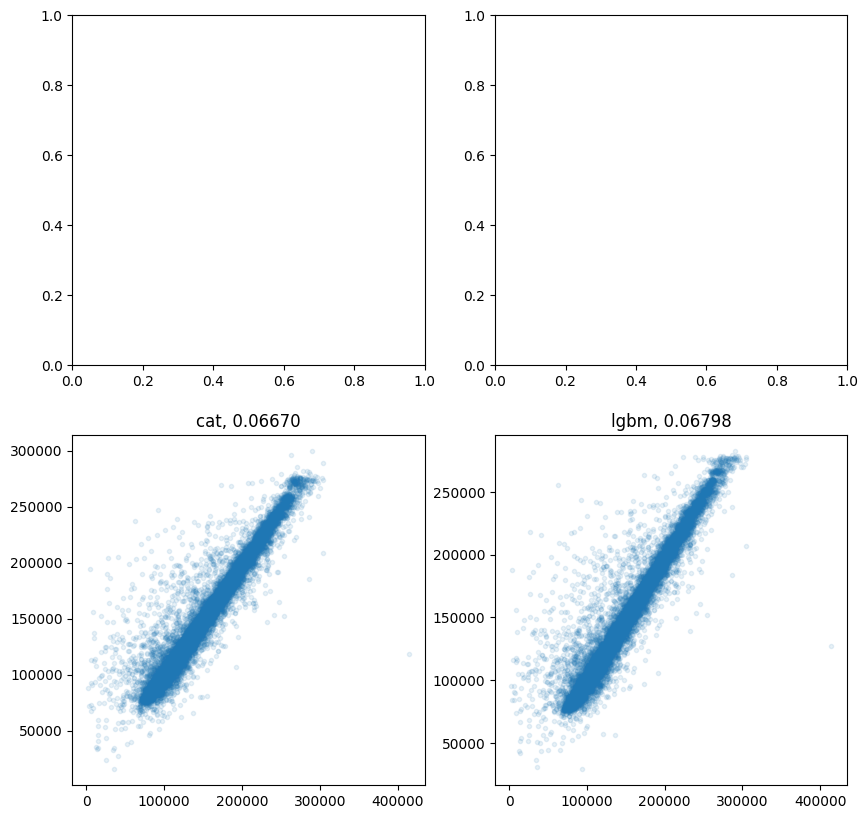

In [11]:
def scatter(ax, y_true, y_pred, y_scaler=scaler_y, label="", suptitle=""):
    ax.plot(y_scaler.inverse_transform(y_true.reshape(-1, 1)),
                y_scaler.inverse_transform(y_pred.reshape(-1, 1)), '.',
                alpha=0.1, label=label)
    ax.set_title(suptitle)


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scatter(axs[1, 0], y_val, cat.predict(X_val),
        label="cat", suptitle=f"cat, {rel_mae(y_val, cat.predict(X_val)):0.5f}")
scatter(axs[1, 1], y_val, lgbm.predict(X_val),
        label="lgbm", suptitle=f"lgbm, {rel_mae(y_val, lgbm.predict(X_val)):0.5f}")
plt.show()



In [52]:
def study_cat(features=X_transformed, targets=y_transformed, n_trials=100):
    def objective(trial: optuna.Trial, feature_values, target_values, n_splits=3) -> float:
        params = {
            "iterations": trial.suggest_int("iterations", 100, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
            "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "verbose": False,
            "task_type": "GPU",
            "loss_function": trial.suggest_categorical("loss_function", ["Lq", ]),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Plain", ])
        }
        if params["loss_function"] == "Lq":
            q = trial.suggest_float("lq_level", 1.0, 3.0)
            params["loss_function"] = f"Lq:q={q}"
        cat_clf = CatBoostRegressor(**params)
        total_log_loss = 0.
        skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_index, val_index in skf.split(feature_values, target_values):
            X_train = feature_values[train_index]
            X_val = feature_values[val_index]
            y_train = target_values[train_index]
            y_val = target_values[val_index]
            cat_clf.fit(X_train, y_train)
            total_log_loss += rel_mae(y_val, cat_clf.predict(X_val))
        return total_log_loss / n_splits

    study = optuna.create_study(direction="minimize")
    optuna.logging.set_verbosity(optuna.logging.INFO)
    study.optimize(lambda t: objective(t,
                                       features,
                                       targets,
                                       ),
                                       n_trials=n_trials)
    return study

cat_study = study_cat()

[I 2023-05-21 18:14:49,553] A new study created in memory with name: no-name-e6ae20c1-02d0-4f42-aca3-35aa6abe6060
[I 2023-05-21 18:14:52,792] Trial 0 finished with value: 0.08406853969944444 and parameters: {'iterations': 149, 'learning_rate': 0.008463716060015442, 'depth': 8, 'l2_leaf_reg': 1.4518499168247932e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1006164405409847e-07, 'bagging_temperature': 5.487917431396188, 'od_type': 'IncToDec', 'od_wait': 23, 'loss_function': 'Lq', 'boosting_type': 'Plain', 'lq_level': 1.3026769952989874}. Best is trial 0 with value: 0.08406853969944444.
[I 2023-05-21 18:14:57,043] Trial 1 finished with value: 0.10331037646131384 and parameters: {'iterations': 482, 'learning_rate': 0.004253644283253036, 'depth': 5, 'l2_leaf_reg': 0.00012908188856164795, 'bootstrap_type': 'Bayesian', 'random_strength': 1.565850235742852e-07, 'bagging_temperature': 1.3553667393963675, 'od_type': 'Iter', 'od_wait': 22, 'loss_function': 'Lq', 'boosting_type': 'Plain'

/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.04976868490010866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04976868490010866
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


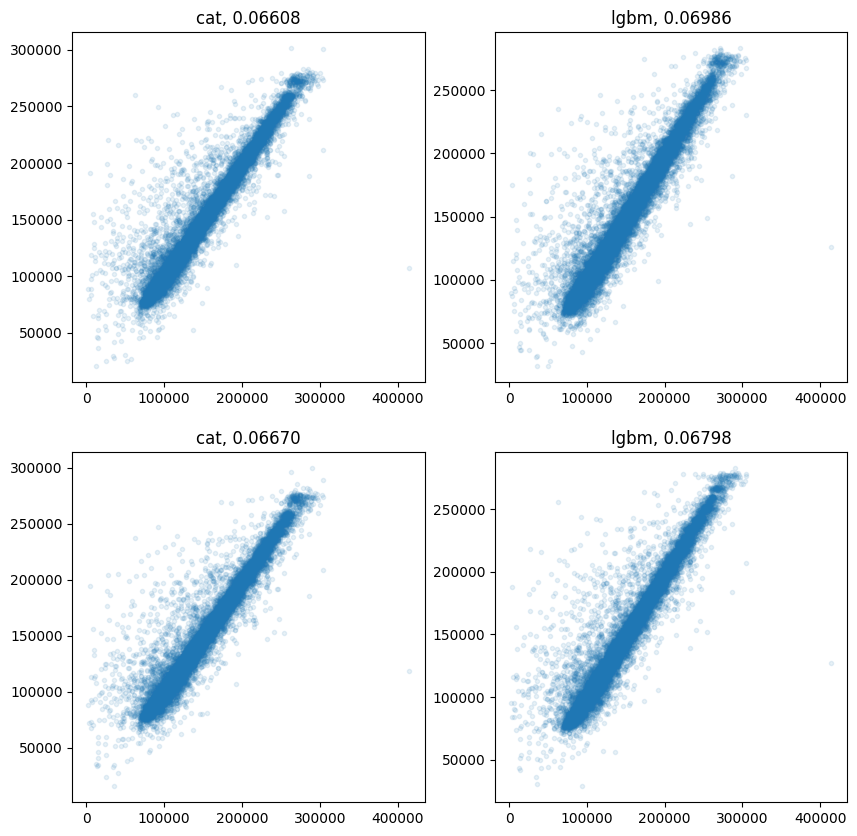

In [15]:
lgbm_best_params = {'n_estimators': 10000, 'learning_rate': 0.14930450998344813, 'num_leaves': 140, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 15, 'lambda_l2': 80, 'min_gain_to_split': 0.04976868490010866, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}

cat_best_params = {'iterations': 1949, 'learning_rate': 0.03984531479902756, 'depth': 5, 'l2_leaf_reg': 9.762733408552352e-05, 'bootstrap_type': 'Poisson', 'random_strength': 0.001057057647553813, 'bagging_temperature': 1.7624409325120856, 'od_type': 'Iter', 'od_wait': 28, 'loss_function': 'Lq:q=1.5611764754856599', 'boosting_type': 'Plain'}

lgbm_opt = LGBMRegressor(**lgbm_best_params)
cat_opt = CatBoostRegressor(
    verbose=False,
    task_type="GPU",
    **cat_best_params)

lgbm_opt.fit(X_train, y_train)
cat_opt.fit(X_train, y_train)


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scatter(axs[0, 0], y_val, cat_opt.predict(X_val),
        label="cat_opt", suptitle=f"cat_opt, {rel_mae(y_val, cat_opt.predict(X_val)):0.5f}")
scatter(axs[0, 1], y_val, lgbm_opt.predict(X_val),
        label="lgbm_opt", suptitle=f"lgbm_opt, {rel_mae(y_val, lgbm_opt.predict(X_val)):0.5f}")
scatter(axs[1, 0], y_val, cat.predict(X_val),
        label="cat", suptitle=f"cat, {rel_mae(y_val, cat.predict(X_val)):0.5f}")
scatter(axs[1, 1], y_val, lgbm.predict(X_val),
        label="lgbm", suptitle=f"lgbm, {rel_mae(y_val, lgbm.predict(X_val)):0.5f}")
plt.show()



In [31]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from lightning import Trainer

from model import LightningFullyConnected

class ScaledEnergyDataset(Dataset):
    def __init__(self, features, targets, x_scaler=scaler_x, y_scaler=scaler_y):
        self.features = features
        self.targets = targets
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        self.features = torch.from_numpy(self.features)
        self.targets = torch.from_numpy(self.targets)

    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

model = LightningFullyConnected(
    in_channels=20,
    out_channels=1,
    hidden_channels=26,
    decode_channels=4,
    hidden_layers=1,
    lr=0.0005845865046613747,
    p_dropout=0.001,
    scheduler=LinearLR,
    loss_fn=lambda pred, target: F.mse_loss(pred, target[:, 0]),
)

trainer = Trainer(devices=1, accelerator="gpu",
                  max_epochs=350, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)])

scaled_train = ScaledEnergyDataset(X_train, y_train)
scaled_val = ScaledEnergyDataset(X_val, y_val)

trainer.fit(model,
            DataLoader(scaled_train, batch_size=5000, num_workers=8),
            DataLoader(scaled_val, batch_size=5000, num_workers=8))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: UserWarning: attribute 'loss_fn' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:360: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'lr_scheduelr'}
  rank_zero_warn(

  | Name  | Type                | Params
----------------------------------------------
0 | model | FullyConnectedModel | 1.4 K 
----------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimate

Sanity Checking: 0it [00:00, ?it/s]

/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[-0.41555053 -0.42452914 -0.41398373 -0.41032347 -0.45361844 -0.40650588
 -0.40929657 -0.4059259  -0.41103286 -0.40601954]
lgbm: 0.06798
cat: 0.06670
cat_opt: 0.06608
nn: 0.29887


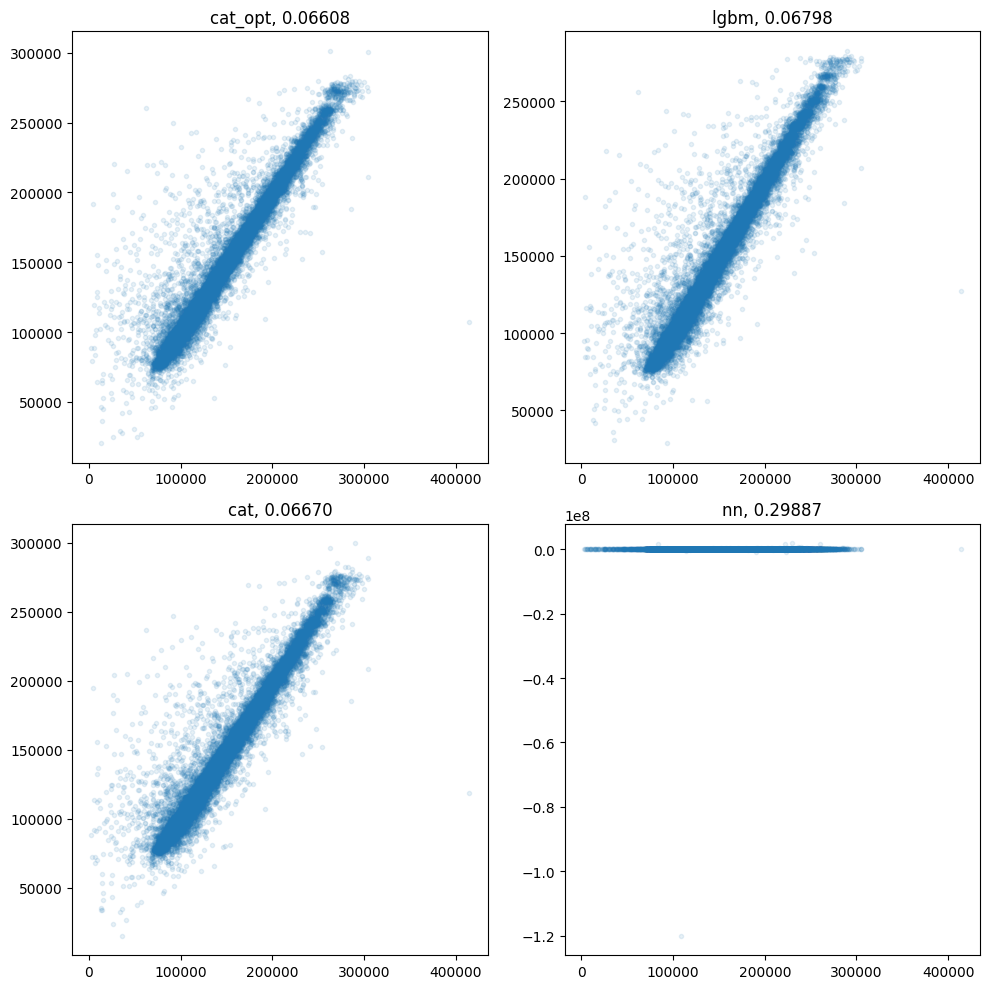

In [32]:
lgbm_pred = lgbm.predict(X_val)
cat_pred = cat.predict(X_val)
cat_opt_pred = cat_opt.predict(X_val)
nn_pred = model(torch.from_numpy(X_val).float()).cpu().detach().numpy().flatten()

print(nn_pred[:10])

print(f"lgbm: {rel_mae(y_val, lgbm_pred):0.5f}")
print(f"cat: {rel_mae(y_val, cat_pred):0.5f}")
print(f"cat_opt: {rel_mae(y_val, cat_opt_pred):0.5f}")
print(f"nn: {rel_mae(y_val, nn_pred):0.5f}")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scatter(axs[0, 0], y_val, cat_opt_pred,
        label="cat_opt", suptitle=f"cat_opt, {rel_mae(y_val, cat_opt_pred):0.5f}")
scatter(axs[0, 1], y_val, lgbm_pred, label="lgbm",
        suptitle=f"lgbm, {rel_mae(y_val, lgbm_pred):0.5f}")
scatter(axs[1, 0], y_val, cat_pred, label="cat", suptitle=f"cat, {rel_mae(y_val, cat_pred):0.5f}")
scatter(axs[1, 1], y_val, nn_pred, label="nn", suptitle=f"nn, {rel_mae(y_val, nn_pred):0.5f}")
plt.tight_layout()
plt.show()

In [45]:
all_models = [lgbm, cat, cat_opt, lgbm_opt]
all_weights = [1 / rel_mae(y_val, model.predict(X_val)) for model in all_models]
all_preds = [scaler_y.inverse_transform(model.predict(X_val).reshape(-1, 1)).flatten() for model in all_models]

print(all_weights)

[array([136403.32315703, 105230.12477242, 161798.60743225, ...,
       152059.02028377, 125325.81568451, 105954.78199099]), array([136754.15938686, 105026.1366729 , 162591.53554023, ...,
       150755.39696213, 127516.81187852, 105137.99612708]), array([136407.89609233, 105667.96459323, 161694.54528763, ...,
       151561.81176502, 127414.93296291, 104588.01678707]), array([137331.23005142, 106011.63879409, 156302.28845874, ...,
       148323.24300815, 127159.38067724, 103293.13707812])]
[14.710453379482026, 14.991836103489154, 15.133721619633988, 14.314480463333085]


In [46]:
from itertools import combinations

all_avg = []
all_bavg = []
all_wavg = []
all_bwavg = []

y_val_pretransformed = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

for n_models in range(1, 5):
    for index, model_comb, weights, pred_vals in zip(combinations(list(range(4)), n_models),
                                          combinations(all_models, n_models),
                                          combinations(all_weights, n_models),
                                          combinations(all_preds, n_models)):
        avg = np.average([model.predict(X_val) for model in model_comb], axis=0)
        wavg = np.average([model.predict(X_val) for model in model_comb], axis=0, weights=weights)
        pre_transformed_avg = np.average(pred_vals, axis=0)
        pre_transformed_wavg = np.average(pred_vals, axis=0, weights=weights)
        all_avg.append((rel_mae(y_val, avg), index))
        all_wavg.append((rel_mae(y_val, wavg), index))
        all_bavg.append((np.mean(np.abs((pre_transformed_avg - y_val_pretransformed) / y_val_pretransformed)), index))
        all_bwavg.append((np.mean(np.abs((pre_transformed_wavg - y_val_pretransformed) / y_val_pretransformed)), index))

print(sorted(all_avg))
print(sorted(all_wavg))
print(sorted(all_bavg))
print(sorted(all_bwavg))

# Best ensembles: w(cat-cato), cato, w(lgbm-cat-cato)

[(0.06601239275887658, (1, 2)), (0.06607759975594062, (2,)), (0.06625425339376033, (0, 1, 2)), (0.06636298741172768, (0, 2)), (0.06646059152084224, (0, 1, 2, 3)), (0.06647354237539115, (1, 2, 3)), (0.0666790853959386, (0, 2, 3)), (0.06670297040982612, (1,)), (0.06688929675698971, (0, 1)), (0.06696018396981168, (2, 3)), (0.06700462282072452, (0, 1, 3)), (0.06729839877397976, (1, 3)), (0.06774745356484135, (0, 3)), (0.06797887014106505, (0,)), (0.0698593289893773, (3,))]
[(0.06601066111387138, (1, 2)), (0.06607759975594062, (2,)), (0.0662457368791708, (0, 1, 2)), (0.06634921777894044, (0, 2)), (0.06644003937538115, (0, 1, 2, 3)), (0.06644176766190284, (1, 2, 3)), (0.0666489752517363, (0, 2, 3)), (0.06670297040982612, (1,)), (0.0668833044996038, (0, 1)), (0.06690376015454148, (2, 3)), (0.06698710786250937, (0, 1, 3)), (0.06726073471041034, (1, 3)), (0.06773415262696615, (0, 3)), (0.06797887014106505, (0,)), (0.0698593289893773, (3,))]
[(0.06601239275887658, (1, 2)), (0.06607759975594062, 

In [51]:
lgbm.fit(X_transformed, y_transformed)
cat.fit(X_transformed, y_transformed)
cat_opt.fit(X_transformed, y_transformed)


w0 = 1 / rel_mae(y_transformed, lgbm.predict(X_transformed))
w1 = 1 / rel_mae(y_transformed, cat.predict(X_transformed))
w2 = 1 / rel_mae(y_transformed, cat_opt.predict(X_transformed))

test_X = test[opt_features]
test_X_transformed = scaler_x.transform(test_X)

ensemble_w2_pred = pd.Series(
    scaler_y.inverse_transform((((w1 * cat.predict(test_X_transformed) + w2 * cat_opt.predict(test_X_transformed)) / (w1 + w2))).reshape(-1, 1)).flatten(),
)

ensemble_w3_pred = pd.Series(
    scaler_y.inverse_transform(((w0 * lgbm.predict(test_X_transformed) + w1 * cat.predict(test_X_transformed) + w2 * cat_opt.predict(test_X_transformed)) / (w0 + w1 + w2)).reshape(-1, 1)).flatten(),
)

cat_opt_pred = pd.Series(
    scaler_y.inverse_transform(cat_opt.predict(test_X_transformed).reshape(-1, 1)).flatten(),
)

SOLUTION_DIR = "/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial/solutions/regression"

cat_opt_pred.to_csv(f"{SOLUTION_DIR}/Regression_AndreasMHermansen_CatBoost.txt")
ensemble_w2_pred.to_csv(f"{SOLUTION_DIR}/Regression_AndreasMHermansen_2ModelWeightedLinearEnsemble.txt")
ensemble_w3_pred.to_csv(f"{SOLUTION_DIR}/Regression_AndreasMHermansen_3ModelWeightedLinearEnsemble.txt")
print("Done!")

/home/amh/Documents/Coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Done!


In [52]:
print(opt_features)

['p_deltaEta2', 'p_EptRatio', 'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_deltaPhi2', 'p_pt_track', 'p_qOverP', 'p_d0', 'p_eCluster', 'p_Rphi', 'p_sigmad0', 'p_d0Sig', 'p_nCells_Lr1_HiG', 'p_ptconecoreTrackPtrCorrection', 'p_deltaPhiFromLastMeasurement', 'p_nCells_Lr2_HiG', 'p_weta1', 'p_Reta', 'p_deltaPhi1', 'p_weta2']
